## Modelo de Previsão Ibovespa - Pos_Tech_DTAT - Grupo 9


Neste notebook, apresentamos uma análise dos dados do IBOVESPA, abrangendo o período de 01/2010 a 07/2024. Incluímos a construção de modelos preditivos e a aplicação de técnicas de séries temporais. A seguir, realizaremos uma análise exploratória dos dados, seguida pelo treinamento e avaliação dos modelos preditivos aplicados ao fechamento do IBOVESPA.


In [1]:
# Importação das bibliotecas utilizadas no projeto.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot, plot_components
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

c:\Users\flavio.castro\Documents\Universidade\Pós Graduação\FIAP\Fase 2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

## 1. Tratamento dos dados para a Análise Exploratória


In [3]:
# Leitura e transformação da base de dados
#------------------------------------------------------
## Números absolutos
df_ibovespa = pd.read_csv('Dados Históricos - Ibovespa.csv', usecols=['Data', 'Último'],thousands='.',dtype={'Último':np.int64,"Data":object})
## Numéros Decimais
# df_ibovespa = pd.read_csv('Dados Históricos - Ibovespa.csv', usecols=['Data', 'Último'],dtype={'Último':float,"Data":object})
df_ibovespa.columns=['ds', 'y']
df_ibovespa['ds'] = pd.to_datetime(df_ibovespa['ds'],format='%d.%m.%Y')
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3600 non-null   datetime64[ns]
 1   y       3600 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 56.4 KB


In [4]:
df_ibovespa.head()

,ds,y
0,2024-07-12,128897
1,2024-07-11,128294
2,2024-07-10,127218
3,2024-07-09,127108
4,2024-07-08,126548


## 2. Análise Exploratória dos Dados

### Visualização dos Dados

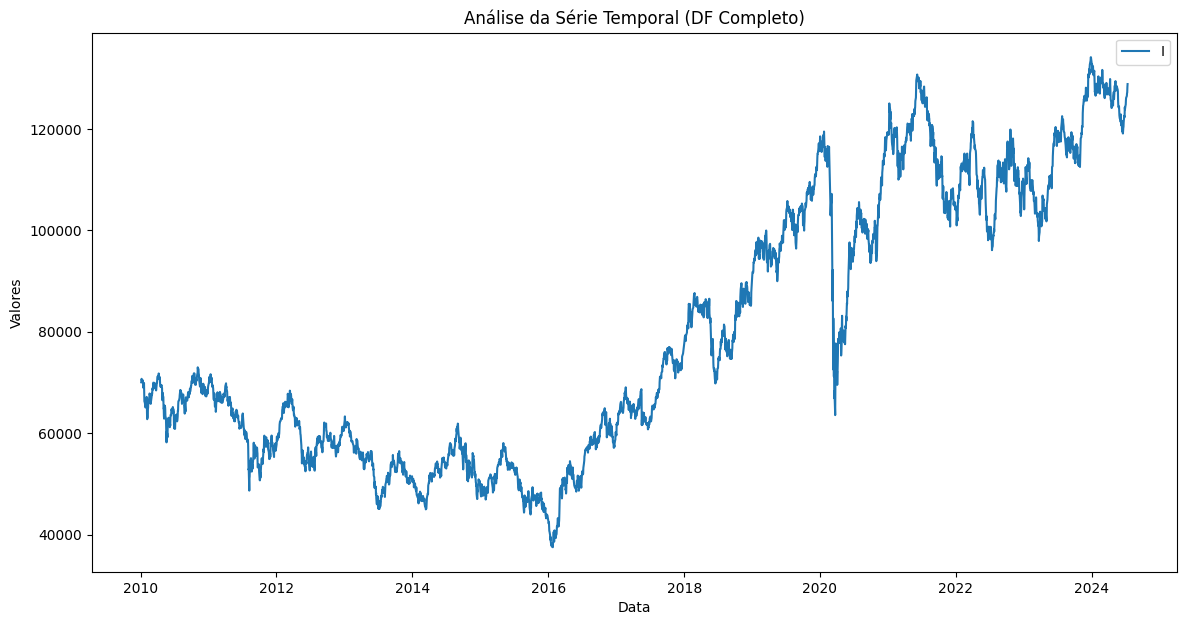

In [5]:
# Visualização dos dados

plt.figure(figsize=(14, 7))
plt.plot(df_ibovespa['ds'],df_ibovespa["y"], label="Último Valor")
plt.title("Análise da Série Temporal (DF Completo)")
plt.xlabel("Data")
plt.ylabel("Valores")
plt.legend("Ibovespa")
plt.show()

### Decomposição da Série Temporal

In [6]:
df_ibovespa.set_index('ds', inplace=True)
df_ibovespa.sort_index(inplace=True)
decomposicao = seasonal_decompose(df_ibovespa['y'], model='additive', extrapolate_trend='freq', period=180)

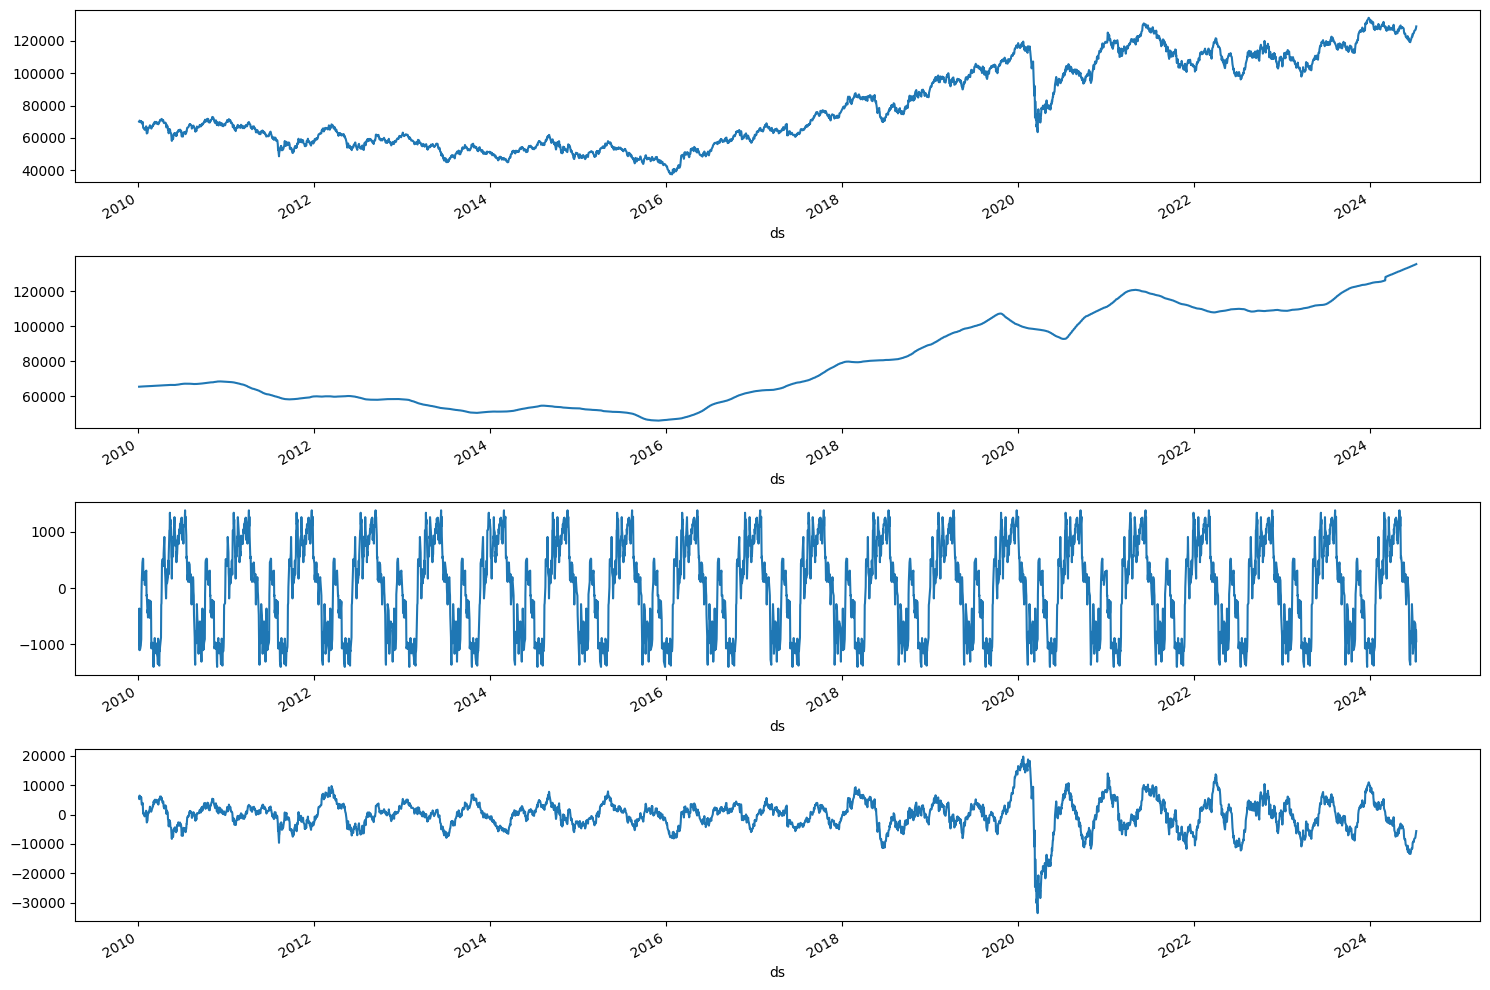

In [7]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

decomposicao.observed.plot(ax=ax1)
decomposicao.trend.plot(ax=ax2)
decomposicao.seasonal.plot(ax=ax3)
decomposicao.resid.plot(ax=ax4)
plt.tight_layout()

### Estatísticas Descritivas

In [8]:
# Estatísticas descritivas
df_ibovespa.describe()

,y
count,3600.000000
mean,79522.877778
std,26349.962576
min,37497.000000
25%,56593.000000
50%,69248.000000
75%,104834.000000
max,134194.000000


## 3. Preparação dos Dados e Modelagem

### Inicialmente, foi importado um conjunto de dados com um histórico extenso; no entanto, para este projeto, utilizaremos apenas os dados a partir de 2023.


In [9]:
# Separando os dados a partir de janeiro de 2023.

df_ibovespa_recorte_2023 = df_ibovespa.loc[(df_ibovespa.index >= '2023-01-01')]


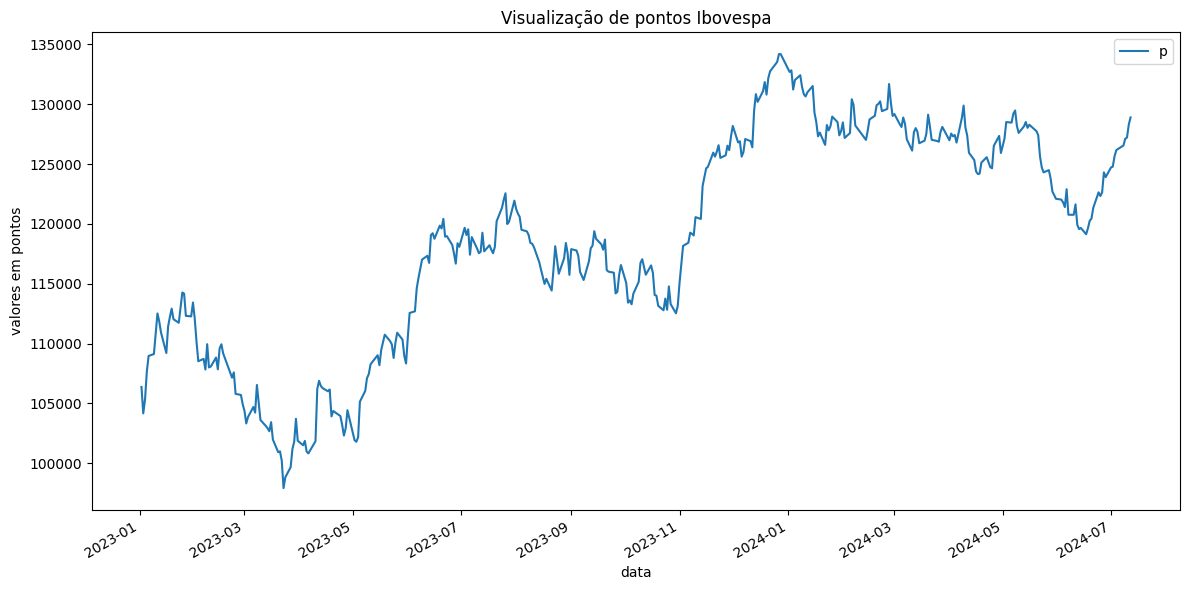

In [10]:
## Plotando os dados novamente com o dataframe reduzindo

df_ibovespa_recorte_2023.plot(y='y',figsize=(12,6))
plt.xlabel('data')
plt.ylabel('valores em pontos')
plt.title('Visualização de pontos Ibovespa')
plt.legend('p')
plt.tight_layout()

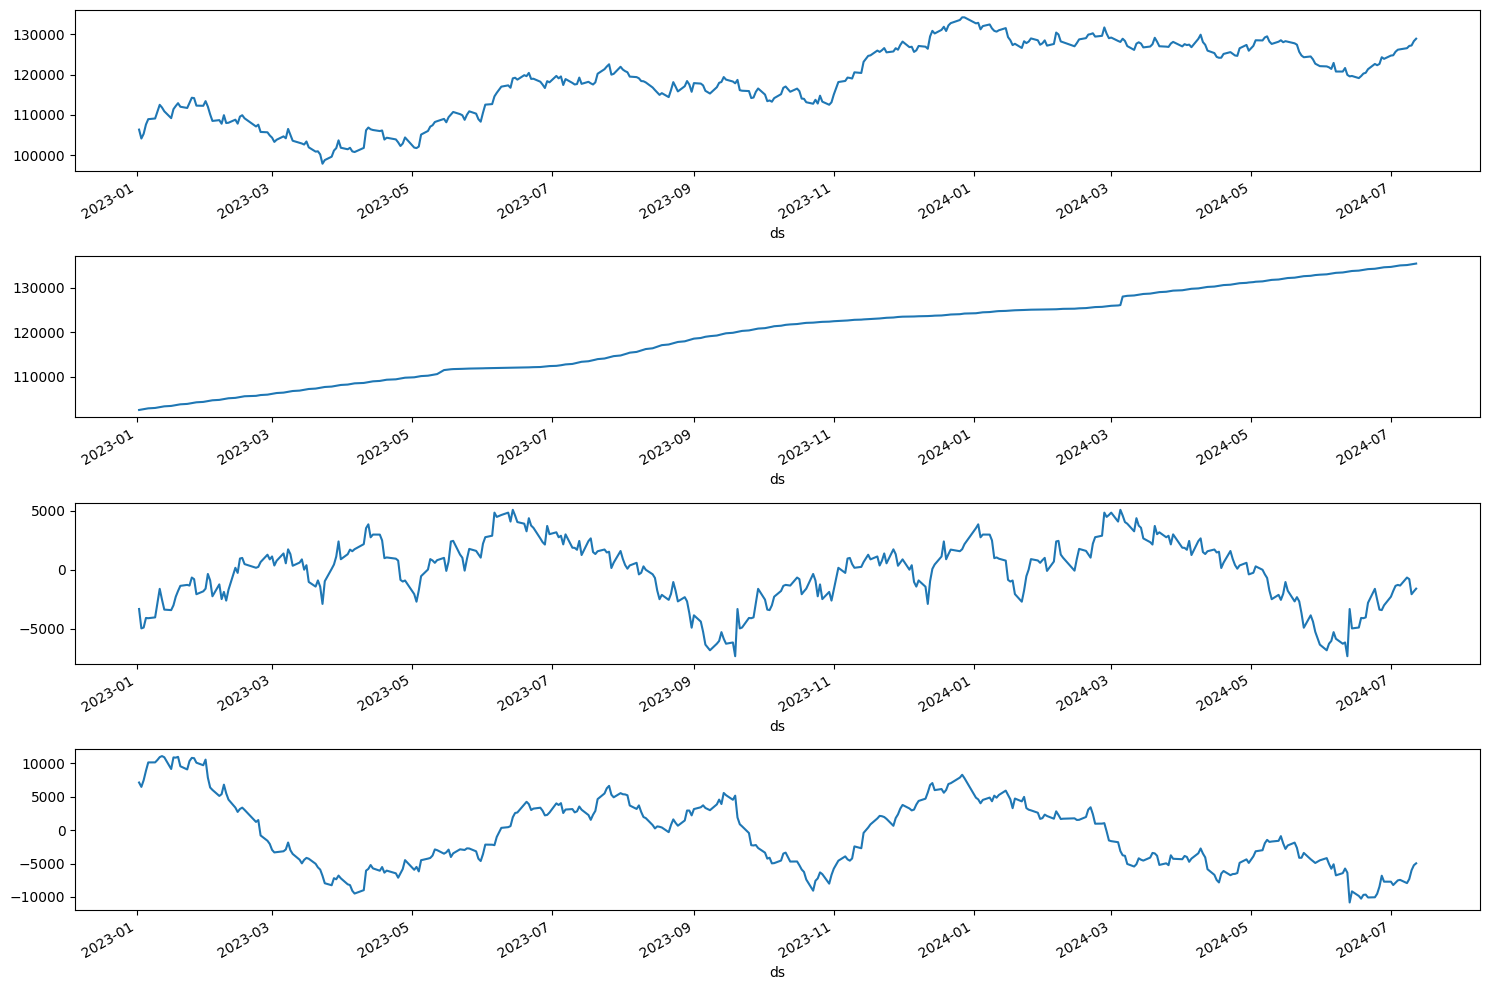

In [11]:
## Avaliando a tendência, sazionalidade e os resíduos do dataset

decomposicao_2 = seasonal_decompose(df_ibovespa_recorte_2023['y'], model='additive', extrapolate_trend='freq', period=180)

# %%
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

decomposicao_2.observed.plot(ax=ax1)
decomposicao_2.trend.plot(ax=ax2)
decomposicao_2.seasonal.plot(ax=ax3)
decomposicao_2.resid.plot(ax=ax4)

plt.tight_layout()


### Aplicando o modelo Prophet

In [12]:
## Normalizando para aplicar o Prophet
df_ibovespa_recorte_2023 = df_ibovespa_recorte_2023.reset_index()
# %%
# importando o modelo e realizando o treinamento
model = Prophet(daily_seasonality=True,yearly_seasonality=True)
# inserido feriados no modelo, porém a base não tem feriados pois a B3 não abre de finais de semana e nem feriados nacionais
model.add_country_holidays(country_name='BR')
model.fit(df_ibovespa_recorte_2023)
# %%
# O forecast de 30 dias com o fechamento do índice Ibovespa
futuro = model.make_future_dataframe(30,freq='D')
# Realizando a predição
forecast = model.predict(futuro)

17:49:07 - cmdstanpy - INFO - Chain [1] start processing
17:49:08 - cmdstanpy - INFO - Chain [1] done processing


### Plotando o gráfico para visualizar a perfomance do modelo.

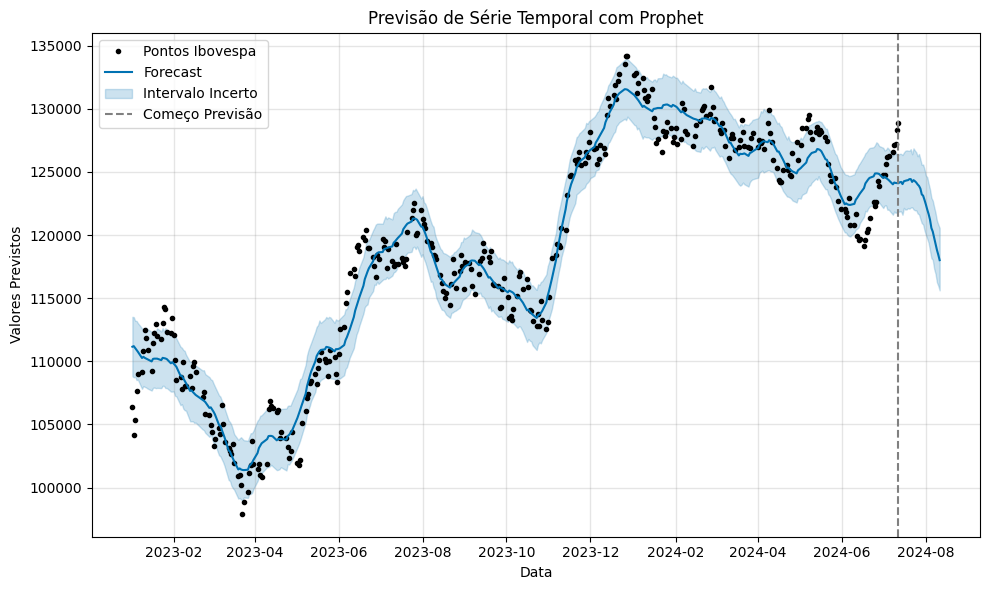

In [13]:
# Plotando as previsões
# plot(model, forecast)
fig1 = model.plot(forecast)
plt.axvline(x=df_ibovespa_recorte_2023['ds'].iloc[-1], color='gray',linestyle='--')
plt.xlabel('Data')
plt.ylabel('Valores Previstos')
plt.title('Previsão de Série Temporal com Prophet')
plt.legend(['Pontos Ibovespa','Forecast','Intervalo Incerto','Começo Previsão'])
plt.tight_layout()
plt.show()

Nesta outra visualização, podemos observar os movimentos de alta e baixa do índice, bem como as mudanças ao longo do tempo.

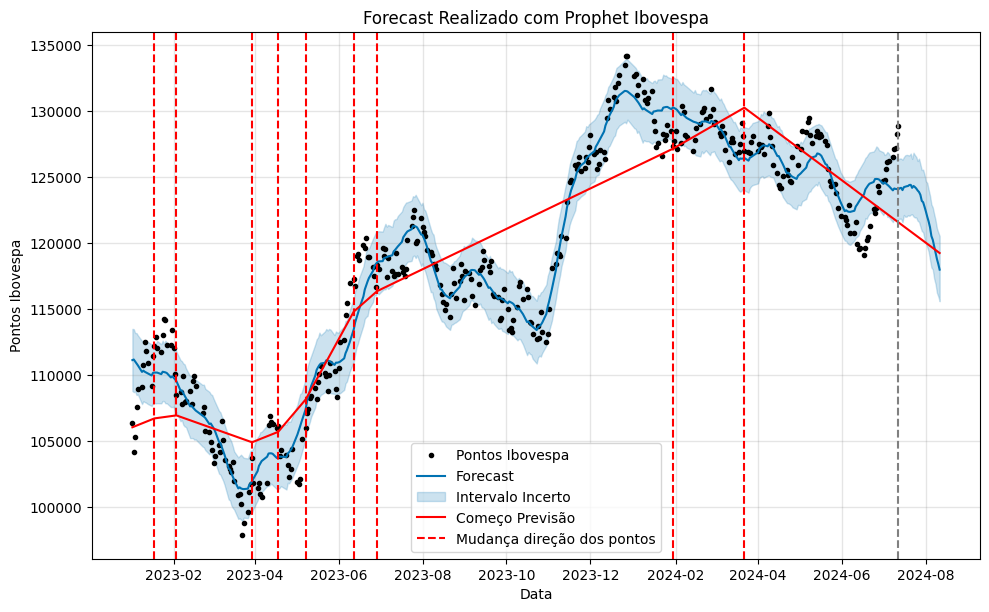

In [14]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

plt.axvline(x=df_ibovespa_recorte_2023['ds'].iloc[-1], color='gray',linestyle='--')
plt.xlabel('Data')
plt.ylabel('Pontos Ibovespa')
plt.title('Forecast Realizado com Prophet Ibovespa')
plt.legend(['Pontos Ibovespa','Forecast','Intervalo Incerto','Começo Previsão','Mudança direção dos pontos'])
plt.show()


### Resultados de Perfomance

Todo modelo criado é necessário que seja avaliado sua perfomance, no Prophet o método mais utilizado é a </br> validação cruzada do modelo para verificar suas principais métricas sendo o média do erro</br> absoluto (mean absolute error), média do erro quadrático (mean squared error), média do erro percentual absoluto </br>(mean absolute percentage error) e a raiz do erro quadrático médio (root mean squared error). </br>

Modelo atual tem 382 datas, utilizaremos para o initial que seria o treinar o do modelo 382 dias. </br>
Para o period utilizamos 15 dias que seriam o intervalo de datas utilizados para a cross validação </br> e deve ser metade do horizon que definimos como 30 dias. 

In [15]:
df_cross_validation = cross_validation(model, initial='382 days', period='15 days', horizon='30 days')

# calcular as métricas do modelo
print("-------- Cálculo das Métricas --------")
df_metricas = performance_metrics(df_cross_validation)

# Calculate MAE, MSE, MAPE, and RMSE
mae = mean_absolute_error(df_cross_validation['y'], df_cross_validation['yhat'])
mse = mean_squared_error(df_cross_validation['y'], df_cross_validation['yhat'])
mape = mean_absolute_percentage_error(df_cross_validation['y'],df_cross_validation['yhat'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae:.0f}')
print(f'Mean Squared Error: {mse:.0f}')
print(f'Mean Absolute Percentage Error: {mape:.3f}')
print(f'Root Mean Squared Error: {rmse:.0f}')
print("-------- Fim da Validação --------")

  0%|          | 0/10 [00:00<?, ?it/s]17:49:11 - cmdstanpy - INFO - Chain [1] start processing
17:49:11 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 1/10 [00:01<00:11,  1.25s/it]17:49:12 - cmdstanpy - INFO - Chain [1] start processing
17:49:13 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 2/10 [00:02<00:10,  1.29s/it]17:49:13 - cmdstanpy - INFO - Chain [1] start processing
17:49:14 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 3/10 [00:03<00:08,  1.20s/it]17:49:14 - cmdstanpy - INFO - Chain [1] start processing
17:49:15 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 4/10 [00:04<00:07,  1.17s/it]17:49:16 - cmdstanpy - INFO - Chain [1] start processing
17:49:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 5/10 [00:06<00:06,  1.23s/it]17:49:17 - cmdstanpy - INFO - Chain [1] start processing
17:49:17 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 6/10 [00:07<00:04,  1.19s/it]17:49:18

-------- Cálculo das Métricas --------
Mean Absolute Error: 5868
Mean Squared Error: 55305445
Mean Absolute Percentage Error: 0.047
Root Mean Squared Error: 7437
-------- Fim da Validação --------


## Conclusão

**Métricas do Modelo:**

- **Erro Absoluto Médio (MAE):** 5.868
- **Erro Quadrático Médio (MSE):** 55.305.445
- **Erro Percentual Absoluto Médio (MAPE):** 4,7%
- **Raiz do Erro Quadrático Médio (RMSE):** 7.437

A análise das métricas indica que, em média, o modelo apresenta um erro de 5.868 pontos. Esse resultado sugere que o modelo possui uma taxa de erro relativamente baixa e demonstra um bom desempenho na previsão dos dados. É importante notar que os índices foram calculados em números absolutos, conforme observado no início do código.
